WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


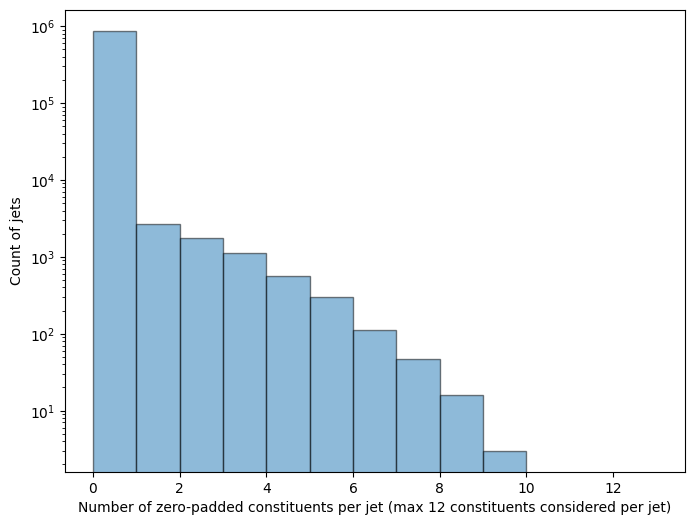

X_train shape: (439999, 12, 3)
X_val   shape: (88001, 12, 3)
X_test  shape: (352000, 12, 3)
Y_train shape: (439999, 5)
Y_val   shape: (88001, 5)
Y_test  shape: (352000, 5)


In [1]:
import h5py
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *
import hls4ml

np.random.seed(42)
tf.random.set_seed(42)

# truncate input with max number of constituents per jet
N = 12

with h5py.File('data.h5', 'r') as f:
    x = f['x'][:, :N, :]
    y = f['y'][:]

# min pt cut on jet constituents
x[x[:, :, 0] < 2] = 0

non_zero_counts = np.sum(np.any(x == 0, axis=(2)), axis=1)
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=range(0, N+2), edgecolor='black', alpha=0.5)
plt.xlabel(f"Number of zero-padded constituents per jet (max {N} constituents considered per jet)")
plt.ylabel("Count of jets")
plt.yscale("log")
plt.show()

# normalization of the pt feature by interquantile range
q5 = np.percentile(x[:, :, 0], 5)
q95 = np.percentile(x[:, :, 0], 95)
x[:, :, 0] = (x[:, :, 0] - 0) / (q95 - q5)

train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
del X_train_val, Y_train_val

In [2]:
phi_dim = 16
rho_dim = 16

quantizer = quantized_bits(8, 0, alpha=1)
quantized_relu = 'quantized_relu(8, 0)'

input_constituent = keras.Input(shape=(N, 3), name='phi_input')

'''
# phi network (dense)
x = QDense(phi_dim, use_bias=True, name='phi1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(input_constituent)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QDense(phi_dim, use_bias=True, name='phi2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu2')(x)
    
x = QDense(phi_dim, use_bias=True, name='phi3', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu3')(x)
'''

# phi network (pointwise conv1d)
x = QConv1D(filters=phi_dim, kernel_size=1, use_bias=False, name='phi1',
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(input_constituent)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QConv1D(filters=phi_dim, kernel_size=1, use_bias=False, name='phi2',
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu2')(x)
    
x = QConv1D(filters=phi_dim, kernel_size=1, use_bias=False, name='phi3',
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu3')(x)

# permutation-invariant Aggregation
x = QActivation(quantized_bits(20, 10, symmetric=0, keep_negative=1), name='act_agg')(x)
x = layers.GlobalAveragePooling1D(name='agg')(x)

# rho network
x = QDense(rho_dim, use_bias=True, name='rho1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu4')(x)

x = QDense(5, use_bias=True, name='rho2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = layers.Softmax(name='softmax')(x)

#model = keras.Model(input_constituent, x, name='deepset_densePhi')
model = keras.Model(input_constituent, x, name='deepset_pointwisePhi')

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "deepset_pointwisePhi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 phi_input (InputLayer)      [(None, 12, 3)]           0         
                                                                 
 phi1 (QConv1D)              (None, 12, 16)            48        
                                                                 
 relu1 (QActivation)         (None, 12, 16)            0         
                                                                 
 phi2 (QConv1D)              (None, 12, 16)            256       
                                                                 
 relu2 (QActivation)         (None, 12, 16)            0         
                                                                 
 phi3 (QConv1D)              (None, 12, 16)            256       
                                                                 
 relu3 (QActivation)         (None, 12, 16)   

In [3]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=10, batch_size=128)

Epoch 1/10
3438/3438 [==============================] - 4s 987us/step - loss: 1.1381 - accuracy: 0.5509 - val_loss: 1.0803 - val_accuracy: 0.5857
Epoch 2/10
3438/3438 [==============================] - 3s 935us/step - loss: 1.0672 - accuracy: 0.5919 - val_loss: 1.0489 - val_accuracy: 0.6072
Epoch 3/10
3438/3438 [==============================] - 3s 958us/step - loss: 1.0483 - accuracy: 0.6023 - val_loss: 1.0366 - val_accuracy: 0.6122
Epoch 4/10
3438/3438 [==============================] - 3s 952us/step - loss: 1.0390 - accuracy: 0.6060 - val_loss: 1.0292 - val_accuracy: 0.6144
Epoch 5/10
3438/3438 [==============================] - 3s 947us/step - loss: 1.0313 - accuracy: 0.6099 - val_loss: 1.0350 - val_accuracy: 0.6101
Epoch 6/10
3438/3438 [==============================] - 3s 950us/step - loss: 1.0284 - accuracy: 0.6118 - val_loss: 1.0223 - val_accuracy: 0.6140
Epoch 7/10
3438/3438 [==============================] - 3s 966us/step - loss: 1.0258 - accuracy: 0.6128 - val_loss: 1.0219 -

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

In [ ]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_pred, ['g','q','w','z','t'])

In [4]:
model.save('model_test.h5')

/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/hofungtsoi/miniforge3/envs/sparse/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
model = qkeras.utils.load_qmodel('model_test.h5')

In [ ]:
Y_pred = model.predict(X_test)

# HLS

In [ ]:
import hls4ml
model = tf.keras.models.Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform'))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform'))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform'))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform'))
model.add(Activation(activation='softmax', name='softmax'))
adam = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
model.summary()
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

In [5]:
#model = tf.keras.models.load_model('model-pointwisePhi.keras')
#model = tf.keras.models.load_model('model-densePhi.keras')

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model']['Strategy'] = 'Latency'
config['LayerName']['phi_input']['Precision'] = 'ap_fixed<12, 4, AP_RND, AP_SAT>'

# for dense Phi
if False:
    config['LayerName']['phi1']['ParallelizationFactor'] = 1
    config['LayerName']['phi1']['ReuseFactor'] = 8
    config['LayerName']['phi1']['Strategy'] = 'Latency'
    #config['LayerName']['phi1']['ConvImplementation'] = 'Pointwise'
    
    config['LayerName']['phi2']['ParallelizationFactor'] = 1
    config['LayerName']['phi2']['ReuseFactor'] = 8
    config['LayerName']['phi2']['Strategy'] = 'Latency'
    #config['LayerName']['phi2']['ConvImplementation'] = 'Pointwise'
    
    config['LayerName']['phi3']['ParallelizationFactor'] = 1
    config['LayerName']['phi3']['ReuseFactor'] = 8
    config['LayerName']['phi3']['Strategy'] = 'Latency'
    #config['LayerName']['phi3']['ConvImplementation'] = 'Pointwise'

config

Interpreting Model
Topology:
Layer name: phi_input, layer type: InputLayer, input shapes: [[None, 12, 3]], output shape: [None, 12, 3]
Layer name: phi1, layer type: QConv1D, input shapes: [[None, 12, 3]], output shape: [None, 12, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: phi2, layer type: QConv1D, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: relu2, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: phi3, layer type: QConv1D, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: relu3, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: act_agg, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: agg, layer type: GlobalAveragePooling1D, input shapes: [[None, 12, 16]], output shape: [None, 16]
Layer name: rho1, layer type: QDense, 

{'Model': {'Precision': {'default': 'fixed<16,6>'},
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'phi_input': {'Trace': False,
   'Precision': 'ap_fixed<12, 4, AP_RND, AP_SAT>'},
  'phi1': {'Trace': False,
   'Precision': {'result': 'auto',
    'weight': 'fixed<8,1,TRN,WRAP,0>',
    'bias': 'fixed<8,1,TRN,WRAP,0>'}},
  'phi1_linear': {'Trace': False, 'Precision': {'result': 'auto'}},
  'relu1': {'Trace': False,
   'Precision': {'result': 'ufixed<8,0,RND_CONV,SAT,0>'}},
  'phi2': {'Trace': False,
   'Precision': {'result': 'auto',
    'weight': 'fixed<8,1,TRN,WRAP,0>',
    'bias': 'fixed<8,1,TRN,WRAP,0>'}},
  'phi2_linear': {'Trace': False, 'Precision': {'result': 'auto'}},
  'relu2': {'Trace': False,
   'Precision': {'result': 'ufixed<8,0,RND_CONV,SAT,0>'}},
  'phi3': {'Trace': False,
   'Precision': {'result': 'auto',
    'weight': 'fixed<8,1,TRN,WRAP,0>',
    'bias': 'fixed<8,1,TRN,WRAP,0>'}},
  'phi3_linear': {'Trac

In [6]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    #project_name='hls_deepset_pointwisePhi_iostream_mod',
    #output_dir='hls_deepset_pointwisePhi_iostream_mod',
    project_name='model_test',
    output_dir='model_test',
    part='xcvu13p-flga2577-2-e',
    io_type='io_parallel',
)

hls_model.compile()
hls_model.write()

Interpreting Model
Topology:
Layer name: phi_input, layer type: InputLayer, input shapes: [[None, 12, 3]], output shape: [None, 12, 3]
Layer name: phi1, layer type: QConv1D, input shapes: [[None, 12, 3]], output shape: [None, 12, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: phi2, layer type: QConv1D, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: relu2, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: phi3, layer type: QConv1D, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: relu3, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: act_agg, layer type: Activation, input shapes: [[None, 12, 16]], output shape: [None, 12, 16]
Layer name: agg, layer type: GlobalAveragePooling1D, input shapes: [[None, 12, 16]], output shape: [None, 16]
Layer name: rho1, layer type: QDense, 

In [ ]:
Y_hls_pred = hls_model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_hls_pred, axis=1))))

In [ ]:
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_hls_pred, ['g','q','w','z','t'])

In [ ]:
del hls_model, config

# test bench

In [7]:
X_test.shape

(352000, 12, 3)

In [8]:
np.random.seed(42)
arr = np.random.rand(5, 12, 3) - 0.5
arr = arr*2

In [9]:
arr[1, :2, :] = 0
arr[2, 2:6, :] = 0
arr[3, 4:10, :] = 0
arr[4, 4:12, :] = 0

In [10]:
arr

array([[[-0.25091976,  0.90142861,  0.46398788],
        [ 0.19731697, -0.68796272, -0.68801096],
        [-0.88383278,  0.73235229,  0.20223002],
        [ 0.41614516, -0.95883101,  0.9398197 ],
        [ 0.66488528, -0.57532178, -0.63635007],
        [-0.63319098, -0.39151551,  0.04951286],
        [-0.13610996, -0.41754172,  0.22370579],
        [-0.72101228, -0.4157107 , -0.26727631],
        [-0.08786003,  0.57035192, -0.60065244],
        [ 0.02846888,  0.18482914, -0.90709917],
        [ 0.2150897 , -0.65895175, -0.86989681],
        [ 0.89777107,  0.93126407,  0.6167947 ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.93122296,  0.8186408 , -0.48244004],
        [ 0.32504457, -0.37657785,  0.04013604],
        [ 0.09342056, -0.63029109,  0.93916926],
        [ 0.55026565,  0.87899788,  0.7896547 ],
        [ 0.19579996,  0.84374847, -0.823015  ],
        [-0.60803428, -0.90954542, -0.34933934],
        [-0.222645

In [11]:
Y_arr = model.predict(arr)
Y_arr

1/1 [==============================] - 0s 130ms/step


array([[0.08588919, 0.21524116, 0.00172805, 0.0370794 , 0.6600622 ],
       [0.08913656, 0.22337918, 0.00165911, 0.03821217, 0.647613  ],
       [0.09641033, 0.34412783, 0.00437231, 0.2795606 , 0.27552894],
       [0.03970742, 0.3680402 , 0.28003296, 0.27032608, 0.04189334],
       [0.11885367, 0.29553336, 0.0011704 , 0.04794361, 0.53649896]],
      dtype=float32)

In [12]:
Y_hls_arr = hls_model.predict(arr)
Y_hls_arr

array([[0.08398438, 0.21582031, 0.00195312, 0.03515625, 0.66699219],
       [0.08984375, 0.21582031, 0.00195312, 0.03710938, 0.66699219],
       [0.09765625, 0.36328125, 0.00488281, 0.30078125, 0.28222656],
       [0.04199219, 0.40039062, 0.29199219, 0.2578125 , 0.04199219],
       [0.11914062, 0.30566406, 0.00097656, 0.04882812, 0.57128906]])

In [13]:
arr = arr.reshape(-1, np.prod(arr.shape[1:]))

In [14]:
with open('model_test/tb_data/tb_input_features.dat', 'w') as my_file:
    for sample in arr:
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')

with open('model_test/tb_data/tb_output_predictions.dat', 'w') as my_file:
    for sample in Y_hls_arr.reshape(-1, np.prod(Y_hls_arr.shape[1:])):
        my_file.write(' '.join(str(x) for x in sample))
        my_file.write('\n')